In [4]:
import sys
sys.path.append("/reg/neh/home/marcgri/Software/skopi/")

import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import time

import skopi as sk
import skopi.gpu as sg

In [5]:
# Create a particle object
particle = sk.Particle()

particle.read_pdb('../input/3iyf.pdb', ff='WK')

# Load beam
beam = sk.Beam('../input/exp_chuck.beam') 

# Load and initialize the detector
det = sk.PnccdDetector(geom = '../../lcls_detectors/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data', 
                       beam = beam)

# Calculate the 3D diffraction volume

In [6]:
mesh_length=128

# Setup the reciprocal space mesh grid for the detector
"""
The edge pixel resolution is slightly larger than the corner resolution of the detector panel.
"""
mesh, voxel_length= det.get_reciprocal_mesh(voxel_number_1d = mesh_length)

# Calculate the 3D diffraction intensity volume
volume = sg.calculate_diffraction_pattern_gpu(mesh, particle, return_type = 'intensity')


"""
Because the Intensity is very low, I would like to increase the intensity a little bit
"""
#volume *= 1e5

'\nBecause the Intensity is very low, I would like to increase the intensity a little bit\n'

# Uniformly Take 10 slices

In [32]:
# Generate 10 images uniformly over 4-sphere
orientation = sk.geometry.get_uniform_quat(num_pts=10)
ten_slices = sk.geometry.take_n_slice(pattern_shape = det.pedestal.shape,
                                      pixel_momentum = det.pixel_position_reciprocal,
                                      volume =volume,
                                      voxel_length= voxel_length,
                                      orientations= orientation)

print np.size(ten_slices,1)
print np.size(ten_slices,2)
print np.size(ten_slices,3)
print np.size(ten_slices,0)
ishape =(len(ten_slices),4,512,512)
orientation.shape
with h5.File('imStack.hdf5','w') as f:
    f.create_dataset('imUniform',shape=ishape,maxshape=ishape,data=ten_slices,dtype=np.int32)
    f.create_dataset('imOrientations',orientation.shape,data=orientation,dtype=np.float32)
with h5.File('imStack.hdf5','r') as f2:
    data2= f2['imUniform'][:] 

Finishing constructing 10 patterns in 8.931494 seconds
4
512
512
10


In [29]:
"""
Process one image
"""
# Convert the one image to photons 
#one_photon_image = det.add_correction_and_quantization(pattern=ten_slices[0])
one_photon_image = det.add_correction_and_quantization(pattern=data2[0])
# Assemble the image stack
one_photon_2d = det.assemble_image_stack(image_stack=one_photon_image)
"""
Process all images
"""
# Convert all slices to photons
#photons = det.add_correction_and_quantization_batch(pattern_batch=ten_slices)
photons = det.add_correction_and_quantization_batch(pattern_batch=data2)
# Assemble all the image stack
photons_2d = det.assemble_image_stack_batch(image_stack_batch=photons)


# Show the image 

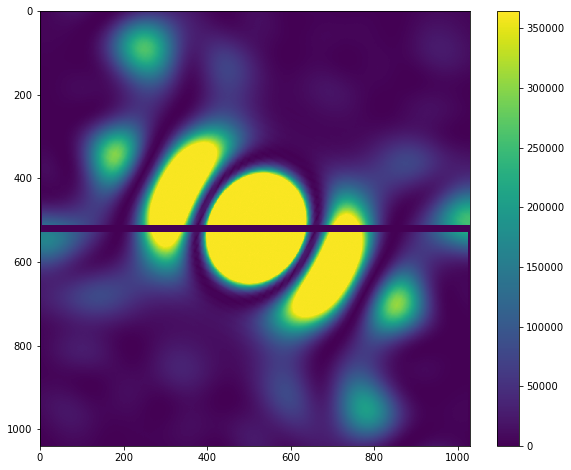

In [30]:
fig = plt.figure(figsize=(10, 8))

plt.imshow(one_photon_2d)#,vmin=0,vmax=10)
plt.colorbar()
plt.show()

# Take 10 random image

In [26]:
#number = 10
#for l in range(10):
orientation =sk.geometry.get_random_quat(num_pts=10)
print orientation

print np.size(orientation,0)
print np.size(orientation,1)
print det.pedestal.shape
print det.pixel_rms.shape
print det.pixel_rms.shape[0]
print sk.geometry.quaternion2rot3d(orientation[0])
#orientation = sk.geometry.get_random_orientations(num_pts=10)
ten_slices = sk.geometry.take_n_random_slices(detector= det,
                                              volume =volume,
                                              voxel_length= voxel_length,
                                              orientations=orientation )

[[ 0.38130373 -0.88216177  0.13354629  0.13354629]
 [-0.25280424  0.55729068 -0.14541872 -0.14541872]
 [-0.07768045  0.65666183 -0.59057542 -0.59057542]
 [-0.60870284 -0.43806776  0.65130558  0.65130558]
 [ 0.69485904  0.57698095 -0.13760794 -0.13760794]
 [ 0.37627641  0.2424634  -0.8862083  -0.8862083 ]
 [-0.12574896 -0.1214093   0.9349832   0.9349832 ]
 [-0.26560306 -0.41911347  0.2932836   0.2932836 ]
 [-0.6251664   0.12249611  0.65678739  0.65678739]
 [ 0.63074219 -0.59565952  0.16245915  0.16245915]]
10
4
(4, 512, 512)
(4, 512, 512)
4
[[ 0.92866155 -0.13377547 -0.33746226]
 [-0.33746226 -0.592088   -0.63707392]
 [-0.13377547  0.70841237 -0.592088  ]]
0
1
2
3


IndexError: index 2514414 is out of bounds for axis 1 with size 2097152

In [23]:
"""
Process one image
"""
# Convert the one image to photons 
one_photon_image = det.add_correction_and_quantization(pattern=ten_slices[0])

# Assemble the image stack
one_photon_2d = det.assemble_image_stack(image_stack=one_photon_image)
"""
Process all images
"""
# Convert all slices to photons
photons = det.add_correction_and_quantization_batch(pattern_batch=ten_slices)

# Assemble all the image stack
photons_2d = det.assemble_image_stack_batch(image_stack_batch=photons)


NameError: name 'ten_slices' is not defined

# Show the image

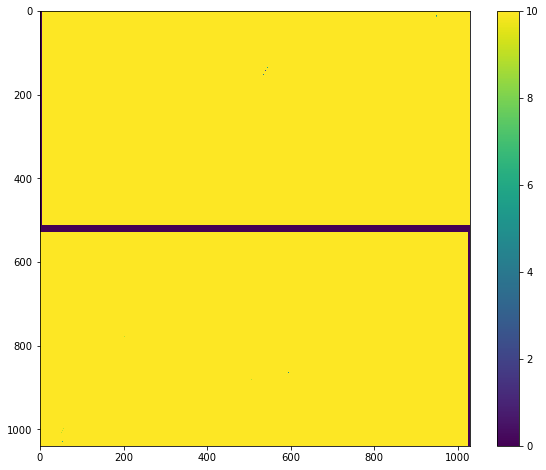

In [15]:
fig = plt.figure(figsize=(10, 8))

plt.imshow(one_photon_2d,vmin=0,vmax=10)
plt.colorbar()
plt.show()